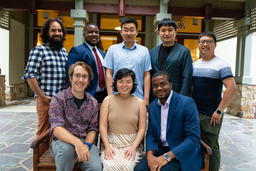

In [12]:
from PIL import Image
import requests
from io import BytesIO

size = (256, 256)
url = "https://cs.vt.edu/content/website_cs_vt_edu/en/faculty-search/jcr:content/article-image.transform/xl-medium/image.jpg"
response = requests.get(url)
content = BytesIO(response.content)
img = Image.open(content)
img.thumbnail(size, Image.LANCZOS)
img.show()

## Noise Process

$q(x_t|x_{t-1}) = N(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_tI)$

$q(x_{1:t} | x_0) = \prod p(x_t|x_{t-1})$
### Reparametriation
$$
    \alpha_t = 1 - \beta_t \\
    \bar \alpha_t = \prod_{i=1}^t \alpha_i \\
    \epsilon \sim N(0, I)\\
    x_t = \sqrt{1-\beta_t}x_{t-1}+\sqrt{\beta_t}\epsilon\\
    = \sqrt{\alpha_t}x_{t-1} + \sqrt{1-\alpha_t}\epsilon\\
    = \sqrt{\alpha_t\alpha_{t-1}}x_{t-2} + \sqrt{1-\alpha_t\alpha_{t-1}}\epsilon\\
    = ... \\
    =\sqrt{\bar\alpha_t}x_0 + \sqrt{1-\bar \alpha_t}\epsilon \\
    q(x_t | x_0) = N(\sqrt{\bar \alpha_t}x_0, \sqrt{1-\bar \alpha_t}I) \\
$$

In [84]:
import numpy as np
import torch

class GaussianDiffusion():
  """
  q is forward process
  p is backward process
  """

  def __init__(self,
               beta: Beta,
               times = None,
               schedulerType = "linear"):
    """
    q(x_t|x_{t-1}) = N(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_tI)
    q(x_{1:t} | x_0) = \prod p(x_t|x_{t-1})

    Reparametriation: for the close-form representation
    \alpha_t = 1 - \beta_t
    \bar \alpha_t = \prod_{i=1}^t \alpha_i
    q(x_t|x_{t-1}) = \sqrt{\bar \alpha_t}x_0 + \sqrt{1-\bar \alpha_t}\epsilon
    q(x_t | x_0) = N(\sqrt{\bar \alpha_t}x_0, \sqrt{1-\bar \alpha_t}I)
    """
    self.B = beta
    betas = self.B.get_schedule(schedulerType)
    self.times = times
    self.alphas = 1.0 - betas
    self.alphas_hat = np.cumprod(self.alphas, axis=0)

    self.alphas_prodprev = np.append(1.0, self.alphas_hat[:-1])

    # For \sqrt{\bar \alpha_t}x_0 + \sqrt{1-\bar \alpha_t}\epsilon
    # and N(\sqrt{\bar \alpha_t}x_0, \sqrt{1-\bar \alpha_t}I)
    # that shared the \sqrt{\bar \alpha_t} and \sqrt{1-\bar \alpha_t}
    self.firstpart_q_alphas_hat = np.sqrt(self.alphas_hat)
    self.secondpart_q_alphas_hat = np.sqrt(1.0 - self.alphas_hat)


  def noise(self, x_0, istorch=False):
    """
    standard distribution sampling
    """
    if istorch:
      return torch.randn_like(x_0)
    else:
      return np.random.randn(*x_0.shape)

  def q_sample(self, x_0, t, noise=None):
      """
      noising
      return x_t
      """
      if noise is None:
          noise = self.noise(x_0) # epsilon
      return extract(self.firstpart_q_alphas_hat, t, x_0.shape) * x_0 \
          + extract(self.secondpart_q_alphas_hat, t, x_0.shape) \
          * noise

def extract(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.
    adapted from: https://github.com/openai/guided-diffusion/blob/22e0df8183507e13a7813f8d38d51b072ca1e67c/guided_diffusion/gaussian_diffusion.py#L895
    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    res = arr[timesteps-1]
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return np.broadcast_to(res, broadcast_shape)

In [19]:
class Beta():
  def __init__(self, start, end, times):
    self.start = start
    self.end = end
    self.times = times

  def get_schedule(self, typeof: str):
    if typeof == "linear":
      return np.linspace(self.start, self.end, self.times)
    elif typeof == "cosine":
      raise NotImplementedError(f"build you own cosine scheduler")
    return None

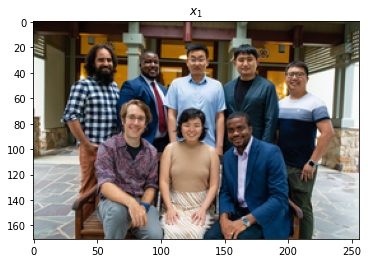

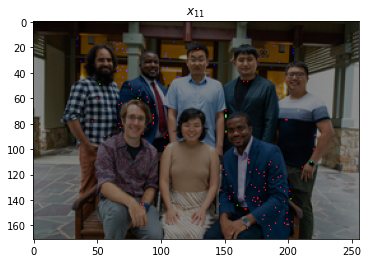

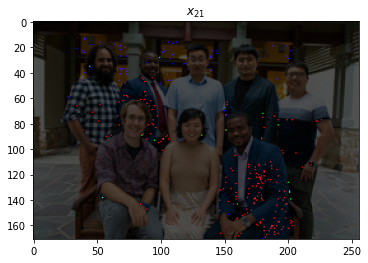

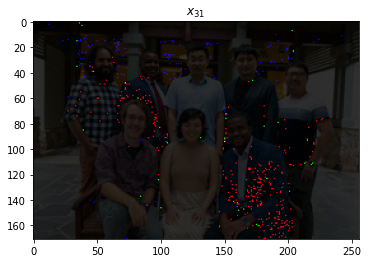

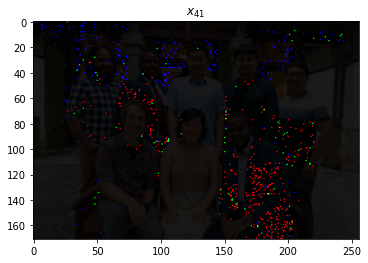

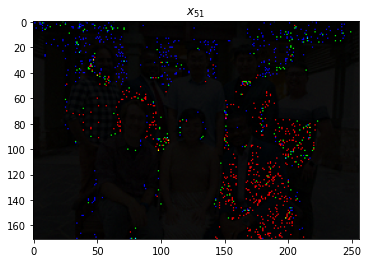

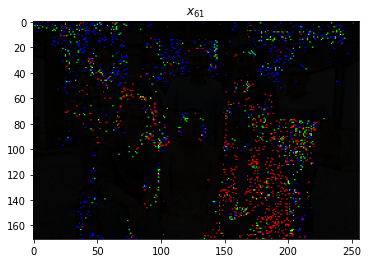

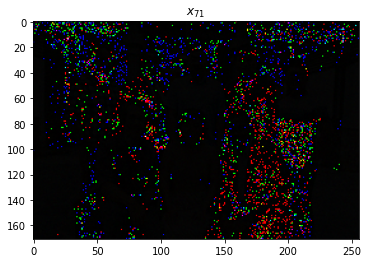

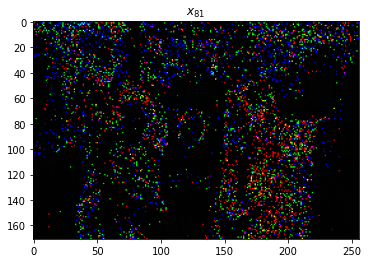

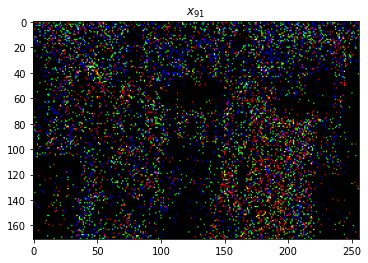

In [85]:
from matplotlib import pyplot as plt
scheduler_end = 0.2
for t in range(1, 100, 10):
  model = GaussianDiffusion(Beta(0.001, scheduler_end, t))
  data = model.q_sample(np.array(img), t)
  plt.imshow(data.astype('uint8'))
  plt.title("$x_{"f"{t}""}$")
  plt.show()

references    
DeepFindr https://www.youtube.com/watch?v=a4Yfz2FxXiY    
OpenAI https://github.com/openai/guided-diffusion    
Berkeley https://www.youtube.com/watch?v=687zEGODmHA   